In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import recall_score, f1_score
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback

In [107]:
X_train_org = np.load('Xtrain1.npy')
Y_train_org = np.load('Ytrain1.npy')
X_extra_org = np.load('Xtrain1_extra.npy') 
X_test = np.load('Xtest1.npy')

In [108]:
X_train_org.shape, Y_train_org.shape

((2783, 2304), (2783,))

0
1
1


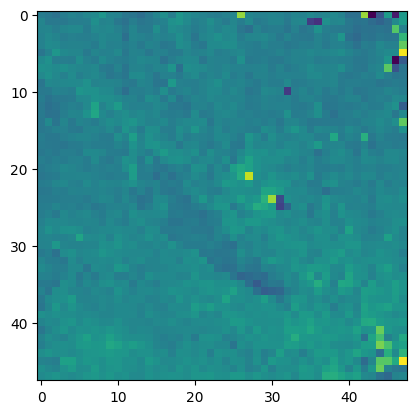

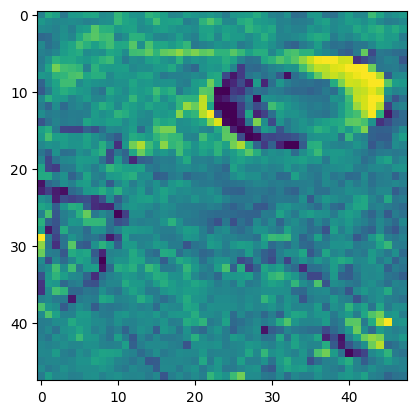

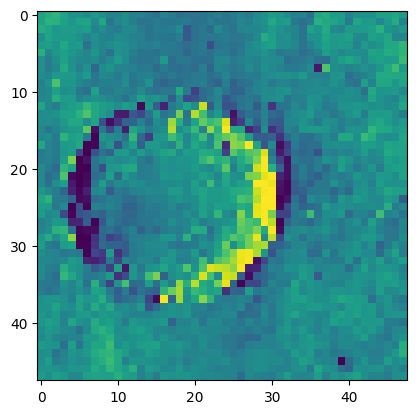

In [109]:
for i in range(3):
    print(Y_train_org[i])
    plt.figure()
    plt.imshow(X_train_org[i].reshape(48,48))

In [110]:
no_crater = X_train_org[np.where(Y_train_org == 0)]
no_crater.shape

(1006, 2304)

In [111]:
X_train_org.shape[0]-no_crater.shape[0]

1777

In [112]:
1777-no_crater.shape[0]

771

Create augmented images without craters to balance data set

In [113]:
# Create an instance of ImageDataGenerator with various augmentations
def custom_transform(image):
    # Randomly choose an action: flip, rotate, or copy
    action = np.random.choice(['flip', 'rotate', 'copy'])    
    if action == 'flip':
        # Randomly decide to flip horizontally or vertically
        if np.random.rand() > 0.5:
            return np.fliplr(image)  # Flip horizontally
        else:
            return np.flipud(image)  # Flip vertically           
    elif action == 'rotate':
        # Randomly choose a rotation: 90°, 180°, or 270°
        rotation = np.random.choice([90, 180, 270])
        if rotation == 90:
            return np.rot90(image, k=1)  # Rotate 90 degrees
        elif rotation == 180:
            return np.rot90(image, k=2)  # Rotate 180 degrees
        elif rotation == 270:
            return np.rot90(image, k=3)  # Rotate 270 degrees        
    return image  # Return a copy of the image (no change)
datagen = ImageDataGenerator(
    preprocessing_function=custom_transform
)

augmented_images = []

# Loop through training images
for img in no_crater:
    img_reshaped = img.reshape((48, 48, 1))
    x = np.expand_dims(img_reshaped, axis=0)  # Expand dims to make it a batch of 1

    # Generate augmented images
    for batch in datagen.flow(x, batch_size=1):
        # Flatten the augmented image
        np_array = batch[0].flatten()
        augmented_images.append(np_array)

        if len(augmented_images) >= 771:  # Stop if you have enough augmented images
            break
    if len(augmented_images) >= 771:
        break
# Convert to NumPy array
augmented_images = np.array(augmented_images)
print(augmented_images.shape)

(771, 2304)


In [114]:
X_train_org.shape

(2783, 2304)

In [115]:
2783+771

3554

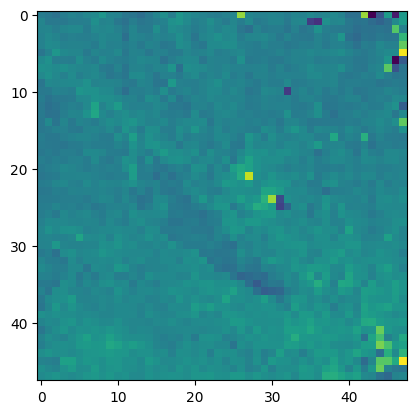

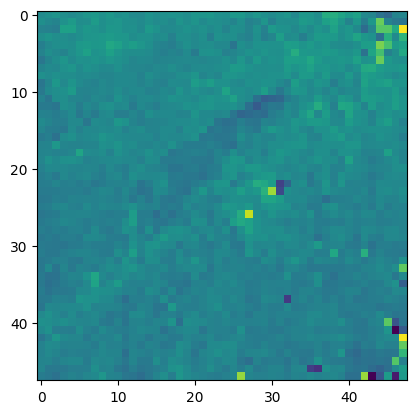

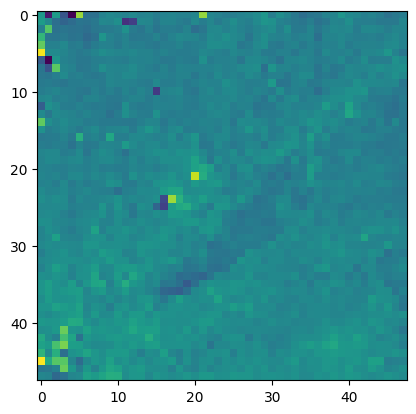

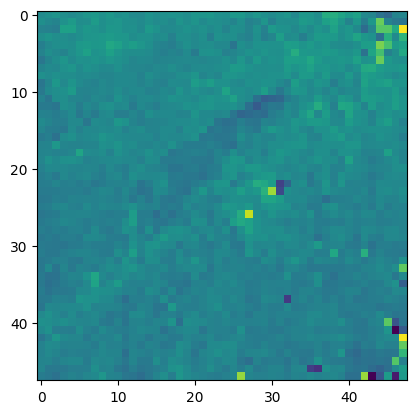

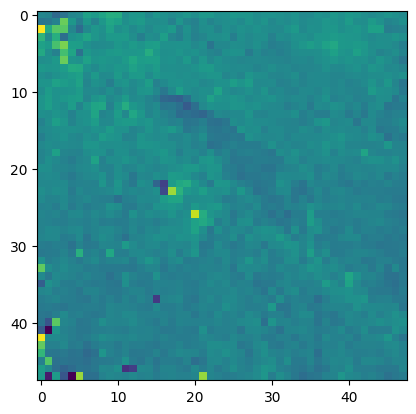

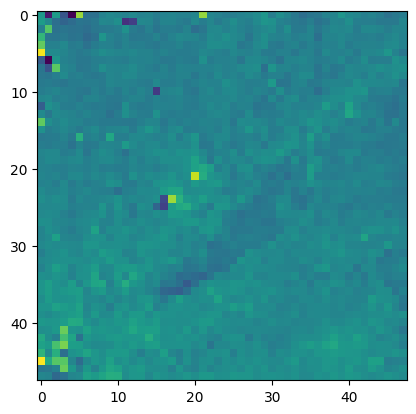

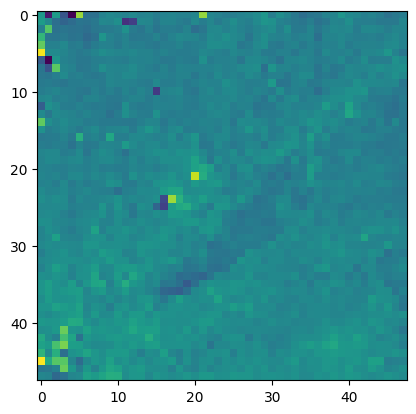

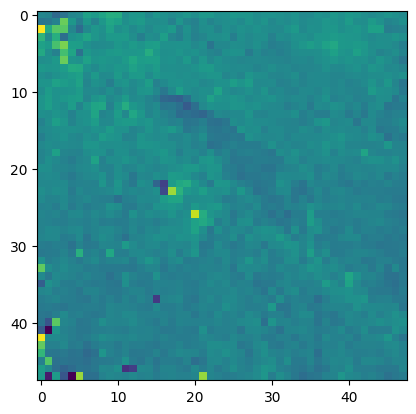

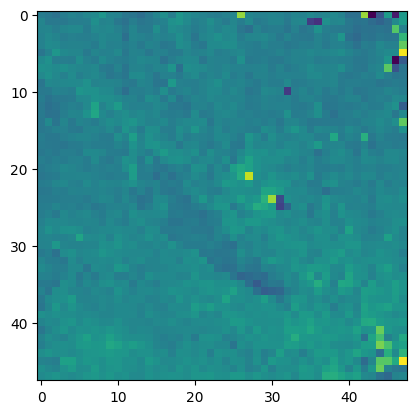

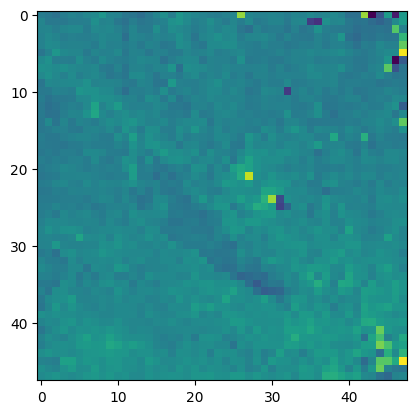

In [116]:
# Visualize augmented images
for i in range(10):
    plt.figure()
    plt.imshow(augmented_images[i].reshape(48,48))

In [117]:
y_augmented_images = np.zeros(len(augmented_images))
Y_train_temp = np.concatenate((Y_train_org,y_augmented_images))
X_train_temp = np.concatenate((X_train_org, augmented_images), axis=0)
X_train_temp.shape, Y_train_temp.shape

((3554, 2304), (3554,))

In [118]:
# Scale data from [0,255] to [0,1]
train_images = (X_train_temp).astype('float32')/255.0
# Get label vectors
train_labels = keras.utils.to_categorical(Y_train_temp,2)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2)

In [119]:
np.sum(y_train,axis=0), np.sum(y_val,axis=0)

(array([1416., 1427.]), array([361., 350.]))

MLP model

In [14]:
from keras.regularizers import l2

In [15]:
# Add fully connected layes with different numbers of neurons
model_MLP = Sequential()

model_MLP.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model_MLP.add(Dropout(0.3))  # Increased dropout for regularization
model_MLP.add(Dense(64, activation='relu'))
model_MLP.add(Dropout(0.3))  # Increased dropout for regularization
model_MLP.add(Dense(32, activation='relu'))
model_MLP.add(Dense(2, activation='softmax'))  # Assuming binary classification

model_MLP.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,442 (1.17 MB)

 Trainable params: 305,442 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
16*48**2+16

36880

In [17]:
batch_size=64
epochs=250
lr=0.00005

Epoch 1/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 0.7198 - val_accuracy: 0.5387 - val_loss: 0.6878
Epoch 2/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5002 - loss: 0.7012 - val_accuracy: 0.4866 - val_loss: 0.6873
Epoch 3/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 0.6994 - val_accuracy: 0.4698 - val_loss: 0.6875
Epoch 4/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5291 - loss: 0.6916 - val_accuracy: 0.6315 - val_loss: 0.6900
Epoch 5/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5220 - loss: 0.6944 - val_accuracy: 0.5035 - val_loss: 0.6835
Epoch 6/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5436 - loss: 0.6892 - val_accuracy: 0.5091 - val_loss: 0.6879
Epoch 7/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5379 - loss: 0.6895 - val_accuracy: 0.5598 - val_loss: 0.6788
Epoch 8/250
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5677 - loss: 0.6811 - val_accuracy: 0.6146 - v

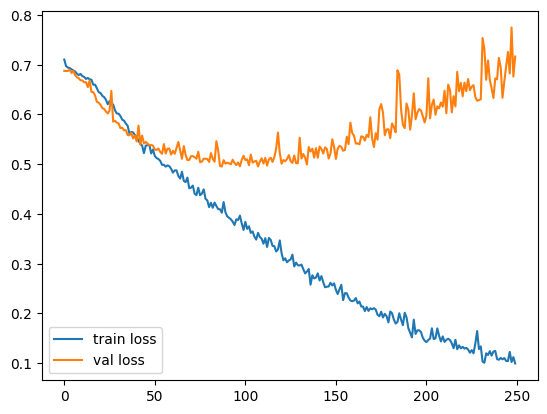

In [18]:
adam = keras.optimizers.Adam(learning_rate = lr)
model_MLP.compile(optimizer = adam,loss = 'categorical_crossentropy', metrics=['accuracy'])

#MLP without early stopping
history = model_MLP.fit(x = X_train,y=y_train,epochs = epochs,batch_size=batch_size,validation_data = (X_val,y_val),verbose = 1)

####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train loss'),
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

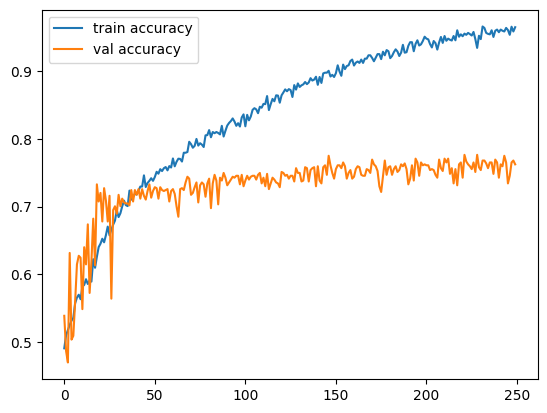

In [20]:
####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['accuracy'], label='train accuracy'),
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

CNN model


In [120]:
# Set up the model
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.5))
model_CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.5))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.3))
model_CNN.add(Dense(2, activation='softmax'))

# Compile the model
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_CNN.summary()

# Data augmentation again
def custom_transform(image):
    # Randomly choose an action: flip, rotate, or copy
    action = np.random.choice(['flip', 'rotate', 'copy'])    
    if action == 'flip':
        # Randomly decide to flip horizontally or vertically
        if np.random.rand() > 0.5:
            return np.fliplr(image)  # Flip horizontally
        else:
            return np.flipud(image)  # Flip vertically           
    elif action == 'rotate':
        # Randomly choose a rotation: 90°, 180°, or 270°
        rotation = np.random.choice([90, 180, 270])
        if rotation == 90:
            return np.rot90(image, k=1)  # Rotate 90 degrees
        elif rotation == 180:
            return np.rot90(image, k=2)  # Rotate 180 degrees
        elif rotation == 270:
            return np.rot90(image, k=3)  # Rotate 270 degrees        
    return image  # Return a copy of the image (no change)
datagen = ImageDataGenerator(
    preprocessing_function=custom_transform
)

# Assuming X_train and y_train are your training data and labels
# Reshape X_train and X_val to (num_samples, 48, 48, 1)
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_recalls = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
        # Get predictions on validation data
        y_pred_probs = self.model.predict(self.validation_data[0])
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(self.validation_data[1], axis=1)

        # Calculate recall and F1 score
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        self.val_recalls.append(recall)
        self.val_f1s.append(f1)

        print(f' — val_recall: {recall:.4f} — val_f1: {f1:.4f}')
        
    def set_val_data(self, val_data):
        self.validation_data = val_data

# Fit the model with data augmentation
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

metrics = Metrics()
metrics.set_val_data((X_val, y_val))

datagen.fit(X_train)

history = model_CNN.fit(datagen.flow(X_train, y_train, batch_size=50),
                         epochs=100,
                         validation_data=(X_val, y_val), callbacks=[reduce_lr, metrics, early_stopping],
                         verbose=1) # add callbacks=[early_stopping] as arg. for early stopping


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,610 (1.64 MB)

 Trainable params: 428,610 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
 7/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4729 - loss: 0.7186 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.5092 - loss: 0.7
 — val_recall: 1.0000 — val_f1: 0.7769
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5093 - loss: 0.6997 - val_accuracy: 0.7173 - val_loss: 0.6745 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.6625 - loss: 0.6
 — val_recall: 0.7543 — val_f1: 0.7619
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6661 - loss: 0.6399 - val_accuracy: 0.7679 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.7833 - loss: 0.5
 — val_recall: 0.8971 — val_f1: 0.8307
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7845 - loss: 0.5036 - val_accuracy: 0.8200 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.8247 - loss: 0.4
 — val_recall: 0.9457 — val_f1: 0.8369
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8247 - loss: 0.4247 - val_accuracy: 0.8186 - val_l

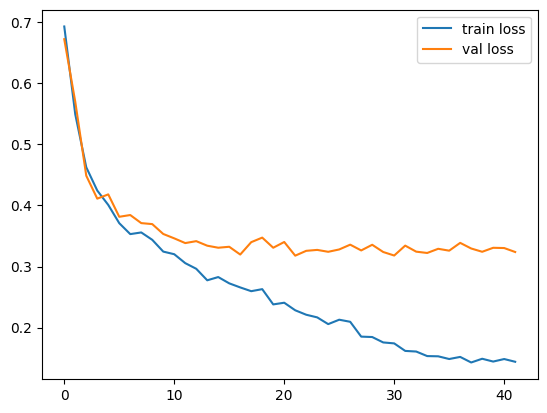

In [94]:
####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train loss'),
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

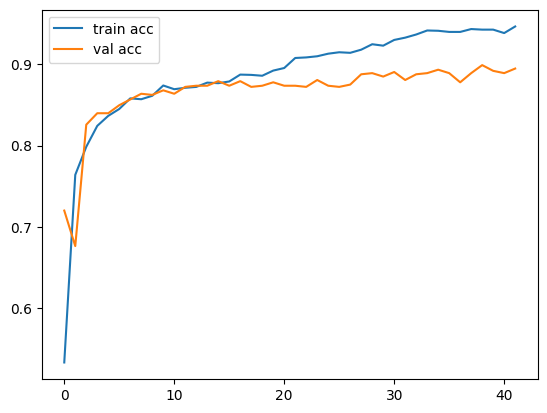

In [95]:
####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['accuracy'], label='train acc'),
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

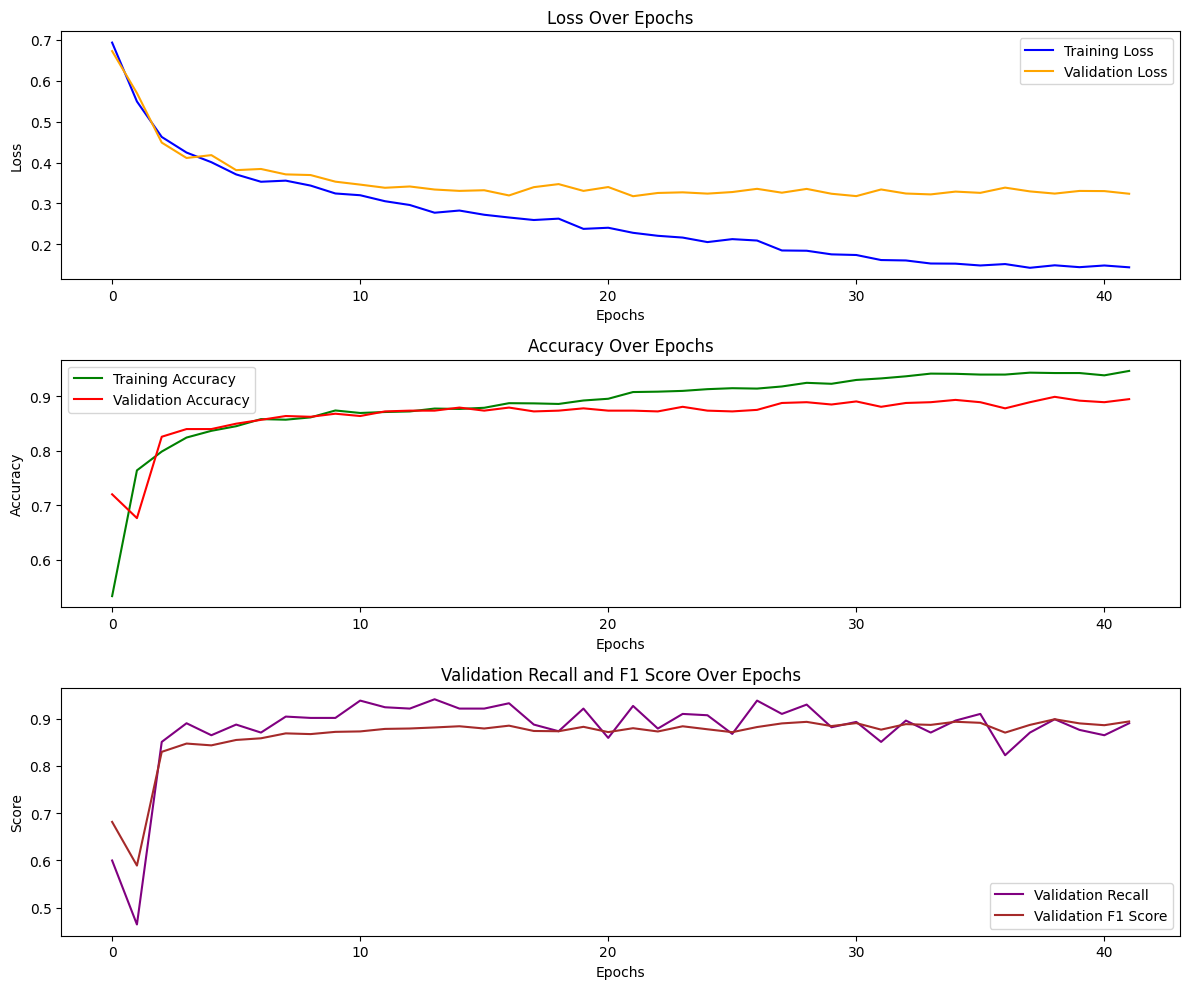

In [96]:
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(3, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Recall and F1 Score
plt.subplot(3, 1, 3)
plt.plot(metrics.val_recalls, label='Validation Recall', color='purple')
plt.plot(metrics.val_f1s, label='Validation F1 Score', color='brown')
plt.title('Validation Recall and F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
metrics.val_f1s[-20:]

[0.8765264586160109,
 0.8825136612021858,
 0.8809849521203831,
 0.881868131868132,
 0.8825136612021858,
 0.8803301237964236,
 0.8852459016393442,
 0.8837209302325582,
 0.881868131868132,
 0.8864569083447332,
 0.8879781420765028,
 0.8879781420765028,
 0.8867667121418827,
 0.8867667121418827,
 0.8864569083447332,
 0.8867667121418827,
 0.8879781420765028,
 0.8879781420765028,
 0.8849315068493151,
 0.8879781420765028]

In [98]:
# Scale unlabelled data from [0,255] to [0,1]
X_unlabeled = (X_extra_org).astype('float32')/255.0
X_unlabeled = X_unlabeled.reshape(-1, 48, 48, 1)
# Get predictions
y_pred_unlabeled = model_CNN.predict(X_unlabeled)
# Choose samles with highest certaincy
confidence_threshold = 0.95
confident_indices = np.where(np.max(y_pred_unlabeled, axis=1) > confidence_threshold)[0]
X_confident = X_unlabeled[confident_indices]
y_confident = np.argmax(y_pred_unlabeled[confident_indices], axis=1)  # Get the predicted class labels
y_confident = keras.utils.to_categorical(y_confident,2)

X_combined = np.concatenate((X_train, X_confident), axis=0)
y_combined = np.concatenate((y_train, y_confident), axis=0)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model_CNN.fit(X_combined, y_combined, batch_size=50,
                         epochs=100,
                         validation_data=(X_val, y_val), callbacks=[reduce_lr, metrics, early_stopping],
                         verbose=1) # add callbacks=[early_stopping] as arg. for early stopping

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.9198 - loss: 0.2
 — val_recall: 0.9014 — val_f1: 0.8779
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9197 - loss: 0.2039 - val_accuracy: 0.8748 - val_loss: 0.3248 - learning_rate: 6.2500e-05
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  - accuracy: 0.9278 - loss: 0.
 — val_recall: 0.9099 — val_f1: 0.8765
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9276 - loss: 0.1886 - val_accuracy: 0.8720 - val_loss: 0.3263 - learning_rate: 6.2500e-05
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.9271 - loss: 0.1
 — val_recall: 0.9099 — val_f1: 0.8825
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9269 - loss: 0.1809 - val_accuracy: 0.8790 - val_loss: 0.3284 - learning_rate: 6.2500e-05
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  - accuracy: 0.9300 - loss: 0.1
 — val_recall: 0.9070 — val_f1: 0.8810
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9297 - loss: 0.1819 - val_a

In [54]:
# Scale test data from [0,255] to [0,1]
test_images = (X_test).astype('float32')/255.0
test_images = test_images.reshape(-1, 48, 48, 1)
test_probs = model_CNN.predict(test_images)
test_probs

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0.9410641 , 0.05893591],
       [0.1347134 , 0.8652867 ],
       [0.8654015 , 0.1345985 ],
       ...,
       [0.07002331, 0.92997664],
       [0.56960356, 0.4303965 ],
       [0.01936284, 0.9806372 ]], dtype=float32)

In [63]:
pred_test = np.argmax(test_probs, axis=1)
pred_test

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,

In [64]:
np.save('prediction',pred_test)

In [55]:
# Scale test data from [0,255] to [0,1]
train_probs = model_CNN.predict(X_train)
temp1 = np.argmax(train_probs, axis=1)
temp1

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([0, 1, 1, ..., 0, 0, 1])

In [60]:
np.sum(np.abs(temp1 - np.argmax(y_train, axis=1)))

142

In [61]:
len(temp1)

2843

In [62]:
142/2843

0.049947238832219486